In [24]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [25]:
index = pd.date_range("2021-09-01", periods=2400, freq="1H")
df = pd.DataFrame({"a":np.arange(2400),"b":list("abcaddbe"*300)}, index=index)
ddf = dd.from_pandas(df, npartitions=10)
ddf

,a,b
npartitions=10,,
2021-09-01 00:00:00,int64,object
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [26]:
ddf.divisions

(Timestamp('2021-09-01 00:00:00', freq='H'),
 Timestamp('2021-09-11 00:00:00', freq='H'),
 Timestamp('2021-09-21 00:00:00', freq='H'),
 Timestamp('2021-10-01 00:00:00', freq='H'),
 Timestamp('2021-10-11 00:00:00', freq='H'),
 Timestamp('2021-10-21 00:00:00', freq='H'),
 Timestamp('2021-10-31 00:00:00', freq='H'),
 Timestamp('2021-11-10 00:00:00', freq='H'),
 Timestamp('2021-11-20 00:00:00', freq='H'),
 Timestamp('2021-11-30 00:00:00', freq='H'),
 Timestamp('2021-12-09 23:00:00', freq='H'))

In [27]:
ddf.partitions[1]

,a,b
npartitions=1,,
2021-09-11,int64,object
2021-09-21,...,...


In [28]:
ddf.b

Dask Series Structure:
npartitions=10
2021-09-01 00:00:00    object
2021-09-11 00:00:00       ...
                        ...  
2021-11-30 00:00:00       ...
2021-12-09 23:00:00       ...
Name: b, dtype: object
Dask Name: getitem, 20 tasks

In [29]:
ddf["2021-10-01": "2021-10-09 5:00"]

,a,b
npartitions=1,,
2021-10-01 00:00:00.000000000,int64,object
2021-10-09 05:00:59.999999999,...,...


In [30]:
ddf["2021-10-01": "2021-10-09 5:00"].compute()

,a,b
2021-10-01 00:00:00,720,a
2021-10-01 01:00:00,721,b
2021-10-01 02:00:00,722,c
2021-10-01 03:00:00,723,a
2021-10-01 04:00:00,724,d
...,...,...
2021-10-09 01:00:00,913,b
2021-10-09 02:00:00,914,c
2021-10-09 03:00:00,915,a
2021-10-09 04:00:00,916,d


In [31]:
ddf.a.mean()

dd.Scalar<series-..., dtype=float64>

In [32]:
ddf.a.mean().compute()

1199.5

In [33]:
ddf.b.unique()

Dask Series Structure:
npartitions=1
    object
       ...
Name: b, dtype: object
Dask Name: unique-agg, 33 tasks

In [34]:
ddf.b.unique().compute()

0    a
1    b
2    c
3    d
4    e
Name: b, dtype: object

In [35]:
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum() - 100

In [36]:
result

Dask Series Structure:
npartitions=1
2021-10-01 00:00:00.000000000    int64
2021-10-09 05:00:59.999999999      ...
Name: a, dtype: int64
Dask Name: sub, 16 tasks

In [37]:
result.compute()

2021-10-01 00:00:00       620
2021-10-01 01:00:00      1341
2021-10-01 02:00:00      2063
2021-10-01 03:00:00      2786
2021-10-01 04:00:00      3510
                        ...  
2021-10-09 01:00:00    158301
2021-10-09 02:00:00    159215
2021-10-09 03:00:00    160130
2021-10-09 04:00:00    161046
2021-10-09 05:00:00    161963
Freq: H, Name: a, Length: 198, dtype: int64

In [38]:
result.dask

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x146724fcc9a0>
 0. from_pandas-0b850a81e4dfe2d272df4dc718065116
 1. loc-cabf0f3185cf56f1f167c341cfe8b54e
 2. getitem-d21e186f1ca6c286e023cb16dd9b402b
 3. series-cumsum-map-1637f6f4d9f481cf08f946a8204379e5
 4. series-cumsum-take-last-94c6ee04439bbe9cf5245389417325b0
 5. series-cumsum-6de27b9b194fa203a3c5b8a1dcb9c1c2
 6. sub-5944e5dd6db5932f78b956d13139054c

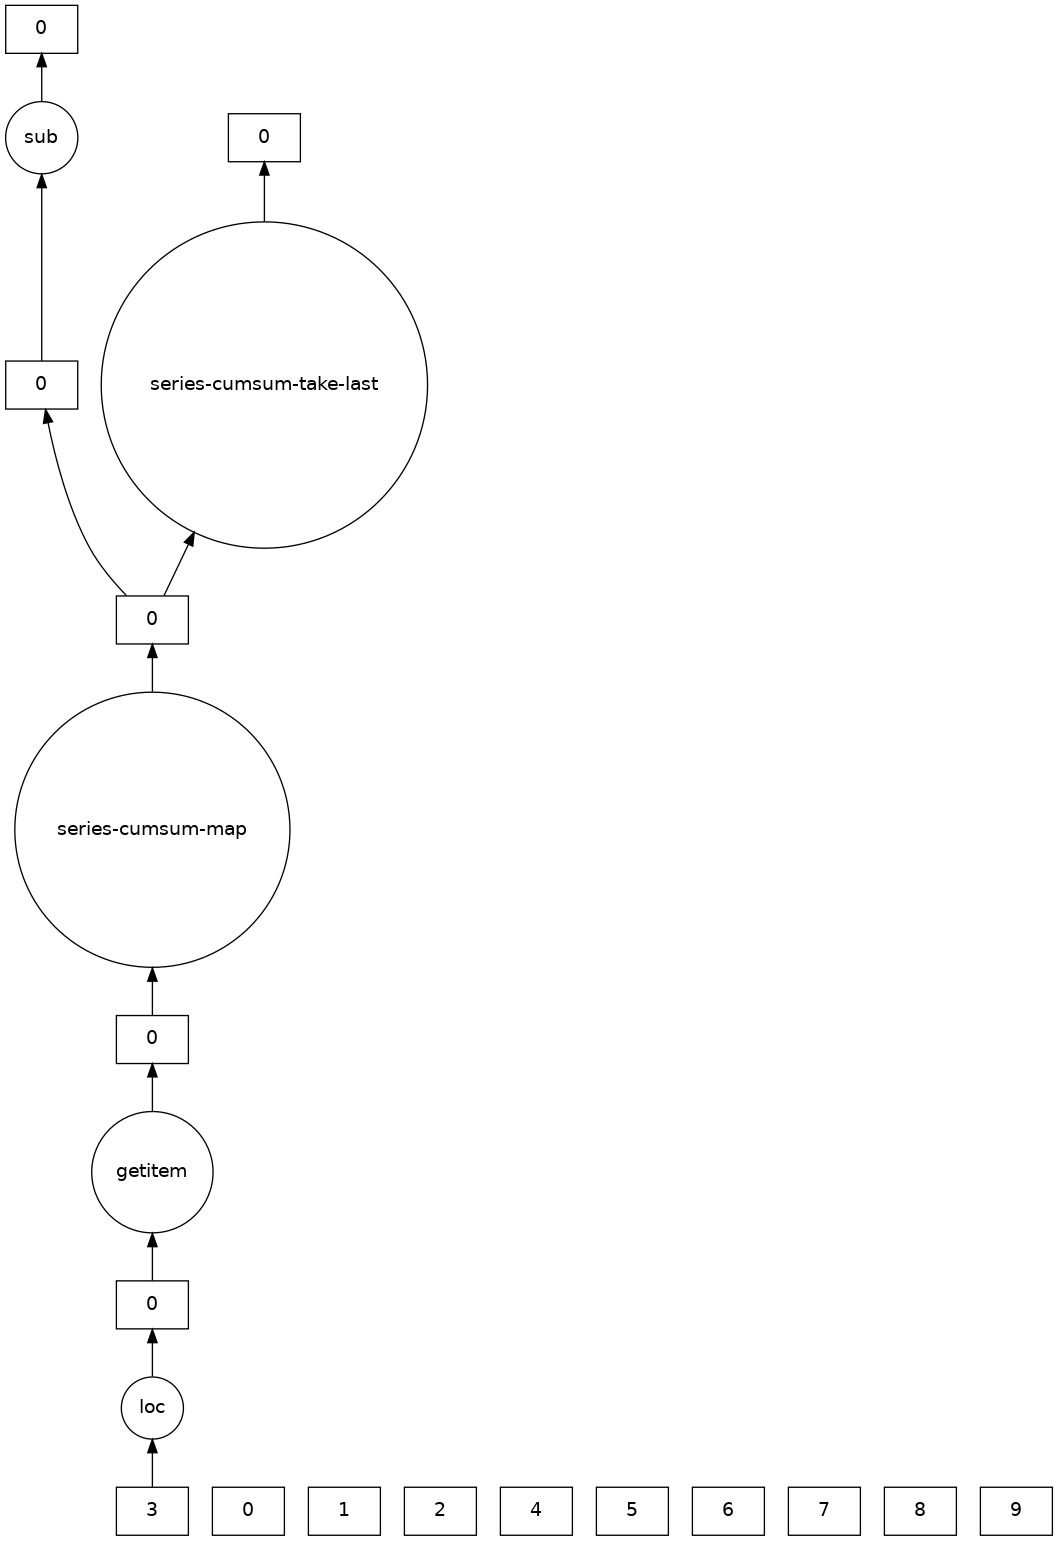

In [41]:
result.visualize()

In [47]:
import dask

@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def add(x, y):
    return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)    # no work has happened yet

c = c.compute()  # This triggers all of the above computations

In [48]:
print(c)

5


In [51]:
from dask.distributed import Client

client = Client()

def inc(x):
    return x + 1

def add(x, y):
    return x + y

a = client.submit(inc, 1)     # work starts immediately
b = client.submit(inc, 2)     # work starts immediately
c = client.submit(add, a, b)  # work starts immediately

c = c.result()                # block until work finishes, then gather result

/home/rgoli/.conda/envs/rapids-22.02/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38441 instead
  warnings.warn(


In [52]:
print(c)

5


In [61]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38441/status,
Dashboard: http://127.0.0.1:38441/status,Workers: 7
Total threads: 28,Total memory: 62.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37439,Workers: 7
Dashboard: http://127.0.0.1:38441/status,Total threads: 28
Started: 1 hour ago,Total memory: 62.00 GiB
Comm: tcp://127.0.0.1:39747,Total threads: 4
Dashboard: http://127.0.0.1:36557/status,Memory: 8.86 GiB
Nanny: tcp://127.0.0.1:39977,


In [57]:
!ip addr

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
2: enp24s0f0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc mq state UP group default qlen 1000
    link/ether 50:6b:4b:3b:f1:c8 brd ff:ff:ff:ff:ff:ff
    inet 10.125.1.103/16 brd 10.125.255.255 scope global noprefixroute enp24s0f0
       valid_lft forever preferred_lft forever
3: enp24s0f1: <NO-CARRIER,BROADCAST,MULTICAST,UP> mtu 1500 qdisc mq state DOWN group default qlen 1000
    link/ether 50:6b:4b:3b:f1:c9 brd ff:ff:ff:ff:ff:ff
4: ib0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 65520 qdisc fq_codel state UP group default qlen 256
    link/infiniband 80:00:00:5a:fe:80:00:00:00:00:00:00:b8:59:9f:03:00:25:8b:40 brd 00:ff:ff:ff:ff:12:40:1b:ff:ff:00:00:00:00:00:00:ff:ff:ff:ff
    inet 10.128.1.103/19 brd 10.128.31.255 scope global noprefixroute ib0
       vali

In [58]:
client.dashboard_link

'http://127.0.0.1:38441/status'

In [59]:
type(ddf)

dask.dataframe.core.DataFrame

In [60]:
ddf.persist()

,a,b
npartitions=10,,
2021-09-01 00:00:00,int64,object
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [72]:
import os

data_files = os.listdir('/scratch1/rgoli/aws_customer_reviews')

data_files = [os.path.join('/scratch1/rgoli/aws_customer_reviews', file) for file in data_files]

print(data_files[0:2])

ddf = dd.read_csv(data_files, sep='\t')

['/scratch1/rgoli/aws_customer_reviews/amazon_reviews_us_Home_Entertainment_v1_00.tsv.gz', '/scratch1/rgoli/aws_customer_reviews/amazon_reviews_us_Office_Products_v1_00.tsv.gz']


In [69]:
ddf.shape

(Delayed('int-d56dc9e1-e23c-4d0b-8442-678403237f09'), 15)

In [73]:
ddf.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

In [75]:
ddf.partitions[0]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
npartitions=1,,,,,,,,,,,,,,,
,object,int64,object,object,int64,object,object,int64,int64,int64,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [76]:
ddf.to_parquet('/scratch1/rgoli/aws_customer_reviews_parquet/')

ParserError: Error tokenizing data. C error: Expected 15 fields in line 1598, saw 22


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


In [77]:
ddf.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

In [78]:
ddf.total_votes.sum().compute()

ParserError: Error tokenizing data. C error: Expected 15 fields in line 1598, saw 22


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


In [79]:
ddf.persist()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
npartitions=46,,,,,,,,,,,,,,,
,object,int64,object,object,int64,object,object,int64,int64,int64,object,object,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [80]:
ddf.compute()

ParserError: Error tokenizing data. C error: Expected 15 fields in line 8021, saw 22


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distribu